In [1]:
import numpy as np
import ase.io as ase_io
from ase import Atoms
import tqdm
import time
import nice
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized

from matplotlib import pyplot as plt

In [2]:
def process_structures(structures, shift):
    for structure in structures: 
        structure.cell = [2 * shift, 2 * shift, 2 * shift]
        structure.positions += np.asarray((shift, shift, shift))
        structure.pbc=True
        structure.wrap()

In [3]:
structures = ase_io.read('structures.xyz', 
                         index = '0:500')

process_structures(structures, 100)

#process_structures(structures_val)


In [4]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    
print(coefficients[1].shape)

100%|██████████| 2/2 [00:00<00:00, 165.53it/s]

(2000, 10, 6, 11)


In [5]:
def normalize_coefficients(coefficients):
    for key in coefficients.keys():
        coefficients[key] = coefficients[key] / np.sqrt(np.sum(coefficients[key][:, :, 0, 0] ** 2, axis = 1))[:, np.newaxis, np.newaxis, np.newaxis]

In [6]:
print(coefficients[6][0, 0, 0, 0])
normalize_coefficients(coefficients)
print(coefficients[6][0, 0, 0, 0])

5.733729249697946e-06
0.06221528852748573


In [7]:
c_trans = StandardSequence([StandardBlock(ThresholdExpansioner(500),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(300),
                                                  ThresholdExpansioner(500, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(200)),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(300),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(200)),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(300),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(200)),
                                StandardBlock(ThresholdExpansioner(num_expand = 500),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(300),
                                                  ThresholdExpansioner(num_expand = 1000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(200))
                                   ])

In [8]:
begin = time.time()
c_trans.fit(coefficients[6][0:1000])
print(time.time() - begin)

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 3000, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 500. Number of pca components is 300
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 1500, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 2, i. e. to

/home/pozdn/nice/nice/transformers/purifiers.py:120: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 200, desired number of data points is 2000, actual number of data points (n_env * (l + 1)) is 1000, since number of environments is 500, and l is 1
  warnings.warn("Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is {}, desired number of data points is {}, actual number of data points (n_env * (l + 1)) is {}, since number of environments is {}, and l is {}".format(total_num, num_fit_now, new_block.shape[0] * (l + 1), new_block.shape[0], l))
/home/pozdn/nice/nice/transformers/purifiers.py:120: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 210, desired number of data points is 2100, actual number of data points (n_env * (l + 1)) is 1500, since number of environments is 500, and l is 2
  warnings.

/home/pozdn/nice/nice/transformers/purifiers.py:120: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 310, desired number of data points is 3100, actual number of data points (n_env * (l + 1)) is 1500, since number of environments is 500, and l is 2
  warnings.warn("Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is {}, desired number of data points is {}, actual number of data points (n_env * (l + 1)) is {}, since number of environments is {}, and l is {}".format(total_num, num_fit_now, new_block.shape[0] * (l + 1), new_block.shape[0], l))
/home/pozdn/nice/nice/transformers/purifiers.py:120: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 300, desired number of data points is 3000, actual number of data points (n_env * (l + 1)) is 2000, since number of environments is 500, and l is 3
  warnings.

/home/pozdn/nice/nice/transformers/compressors.py:73: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 1500, while number of vectors is 500, dimensionality of single vector (lambd + 1) is 2, i. e. total number of points is 1000. Number of pca components is 300
  warnings.warn("given data is less than desired number of points to fit pca. Desired number of points to fit pca is {}, while number of vectors is {}, dimensionality of single vector (lambd + 1) is {}, i. e. total number of points is {}. Number of pca components is {}".format(num_fit_now, data.covariants_.shape[0], (lambd + 1), data.covariants_.shape[0] * (lambd + 1), n_components_now), RuntimeWarning)
/home/pozdn/nice/nice/transformers/purifiers.py:50: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 257, desired number of environments is 2570, actual number of environments is 500
  warnings.wa

567.1848654747009


In [9]:
invariants_even = c_trans.transform(coefficients[6][0:1000], return_only_invariants = True)

In [10]:
for nu in invariants_even.keys():
    print("shape of invariants for nu = {} : {}".format(nu, invariants_even[nu].shape))

shape of invariants for nu = 1 : (500, 10)
shape of invariants for nu = 2 : (500, 200)
shape of invariants for nu = 3 : (500, 200)
shape of invariants for nu = 4 : (500, 200)
shape of invariants for nu = 5 : (500, 200)


nu:  1


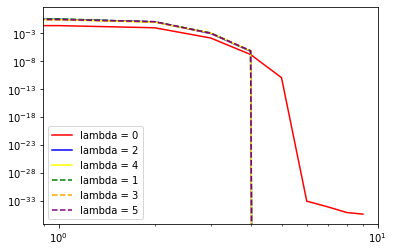

nu:  2


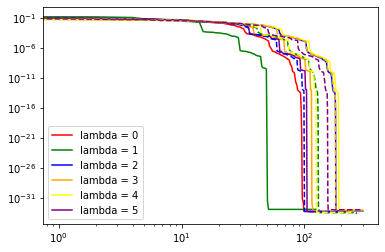

nu:  3


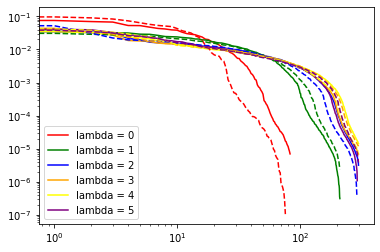

nu:  4


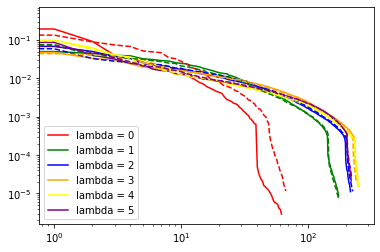

nu:  5


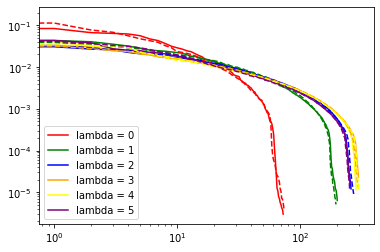

In [12]:
colors = ['r', 'g', 'b', 'orange', 'yellow', 'purple']

print("nu: ", 1)
for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.even_pca_.pcas_[i] is not None):
            plt.plot(c_trans.initial_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))


for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.odd_pca_.pcas_[i] is not None):
            plt.plot(c_trans.initial_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i], label = "lambda = {}".format(i))

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
    
for nu in range(len(c_trans.blocks_)):
    print("nu: ", nu + 2)
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))
        
    
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i] is not None):
                plt.plot(c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()